## Visualize singscore accuracy and misclassifications

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(patchwork))

In [2]:
# Output file
output_file <- file.path("figures", "singscore_misclassified_samples.png")

In [3]:
# Clones for manuscript
# We selected these clones as our initial training, test, holdout and validation sets
# for the manuscript. We selected these after a period of data collection where we
# classified proliferation under Bortezomib and other drugs to determine
# bortezomib and multi-drug resistance. We do not have proliferation values for
# clones not included in this set
select_clones <- c(
    "WT_parental",
    "CloneA",
    "CloneE",
    "WT001",
    "WT002",
    "WT003",
    "WT004",
    "WT005",
    "WT006",
    "WT007",
    "WT010",
    "WT012",
    "WT013",
    "WT014",
    "WT015",
    "BZ001",
    "BZ002",
    "BZ003",
    "BZ004",
    "BZ005",
    "BZ006",
    "BZ007",
    "BZ008",
    "BZ009",
    "BZ010"
)

In [4]:
# Load singscore summary
accuracy_summary_file <- file.path("results", "singscore_accuracy_summary.tsv")

summary_df <- readr::read_tsv(
    accuracy_summary_file, show_col_types = FALSE
) %>%
    dplyr::arrange(prop_high_confidence, desc(prop_inaccurate)) %>%
    dplyr::filter(Metadata_clone_number %in% select_clones)

clone_number_order <- unique(summary_df$Metadata_clone_number)

# Pivot the input dataframe for plotting
summary_df <- summary_df %>%
    dplyr::select(!c(
        total_samples,
        completely_incorrect,
        high_confidence,
        accurate,
        incorrect
    )) %>%
    tidyr::pivot_longer(
        cols = c(
            "prop_completely_incorrect",
            "prop_high_confidence",
            "prop_accurate",
            "prop_inaccurate"
        ),
        names_to = "category",
        values_to = "metric"
    ) 

summary_df$Metadata_clone_number <- factor(
    summary_df$Metadata_clone_number,
    levels = clone_number_order
    )

summary_df$category <- dplyr::recode(
    summary_df$category,
    prop_completely_incorrect = "High incorrect",
    prop_high_confidence = "High correct",
    prop_accurate = "Low correct",
    prop_inaccurate = "Low incorrect"
)

summary_df$category <- factor(
    summary_df$category,
    levels = rev(c("High correct", "Low correct", "Low incorrect", "High incorrect"))
)

print(dim(summary_df))
head(summary_df, 3)

[1] 100   3


Metadata_clone_number,category,metric
<fct>,<fct>,<dbl>
BZ006,High incorrect,0.8181818
BZ006,High correct,0.0000000
BZ006,Low correct,0.0000000


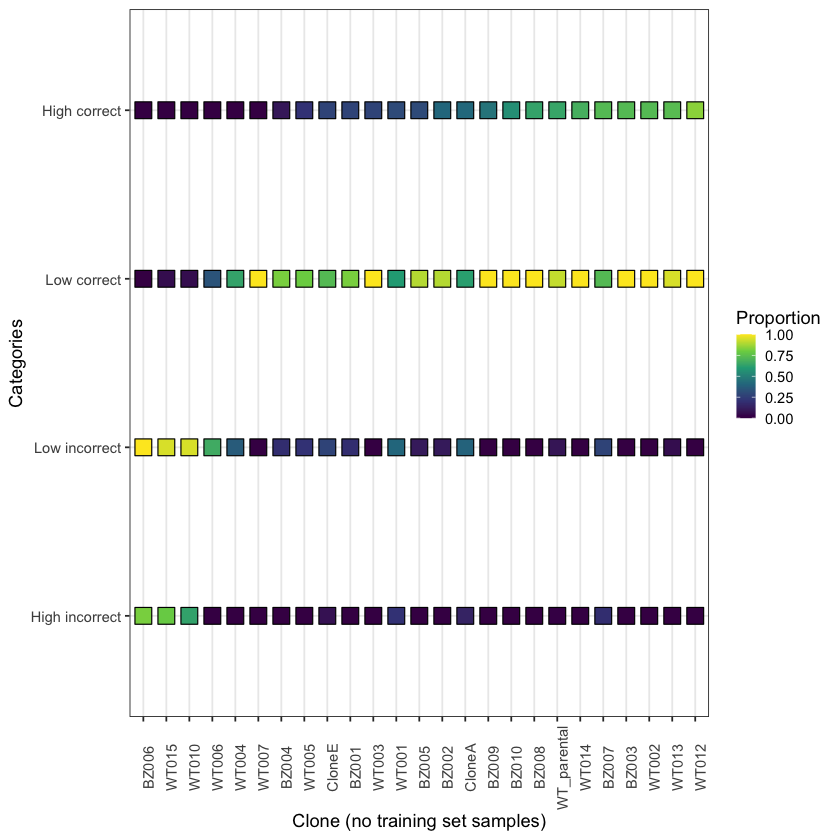

In [5]:
accuracy_summary_gg <- (
    ggplot(summary_df, aes(x = Metadata_clone_number, y = category))
    + geom_point(aes(fill = metric), shape = 22, size = 5)
    + theme_bw()
    + theme(
        axis.text.x = element_text(angle = 90)
    )
    + labs(x = "Clone (no training set samples)", y = "Categories")
    + scale_fill_continuous(name = "Proportion", type = "viridis")
    + guides(fill = guide_colorbar(barwidth = 0.8, barheight = 3.5))
)

accuracy_summary_gg

In [6]:
ks_test_file <- file.path("results", "ks_test_misclassified_differences.tsv")
ks_test_df <- readr::read_tsv(ks_test_file, show_col_types = FALSE) %>%
    tidyr::separate(
        feature,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)

ks_test_df$channel_cleaned <- dplyr::recode(ks_test_df$channel_cleaned,
    "DNA" = "Nucleus",
    "ER" = "ER",
    "AGP" = "AGP",
    "Mito" = "Mito",
    "RNA" = "RNA",
    .default = "other",
    .missing = "other"
)

print(dim(ks_test_df))
head(ks_test_df)

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 58 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 23, 24, 25,
26, ...].”


[1] 90 11


feature,compartment,feature_group,measurement,channel,parameter1,parameter2,clone_type,ks_stat,ks_pval,channel_cleaned
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
Cells_AreaShape_Zernike_4_2,Cells,AreaShape,Zernike,4,2,NA,wildtype,0.2777778,7.342544e-01,other
Cells_AreaShape_Zernike_4_2,Cells,AreaShape,Zernike,4,2,NA,resistant,0.7053968,6.321256e-22,other
Cells_Correlation_K_DNA_AGP,Cells,Correlation,K,DNA,AGP,NA,wildtype,0.4074074,2.724839e-01,Nucleus
Cells_Correlation_K_DNA_AGP,Cells,Correlation,K,DNA,AGP,NA,resistant,0.6336508,2.272664e-17,Nucleus
Cells_Correlation_Manders_Mito_ER,Cells,Correlation,Manders,Mito,ER,NA,wildtype,0.3333333,5.082990e-01,Mito
Cells_Correlation_Manders_Mito_ER,Cells,Correlation,Manders,Mito,ER,NA,resistant,0.4619048,4.217667e-09,Mito


In [7]:
ks_test_group_mean_df <- ks_test_df %>%
    dplyr::group_by(compartment, feature_group, channel_cleaned, clone_type) %>%
    dplyr::summarise(mean_ks_test = mean(ks_stat))

ks_test_group_mean_df$feature_group <- factor(
    ks_test_group_mean_df$feature_group,
    levels = rev(c(
        "AreaShape",
        "Texture",
        "RadialDistribution",
        "Intensity",
        "Granularity",
        "Correlation"
    ))
)

ks_test_group_mean_df$channel_cleaned <- factor(
    ks_test_group_mean_df$channel_cleaned,
    levels = rev(c("AGP", "Nucleus", "ER", "Mito", "RNA", "other"))
)

ks_test_group_mean_df$clone_type <- dplyr::recode(
    ks_test_group_mean_df$clone_type,
    resistant = "Resistant",
    wildtype = "Wildtype",
    prop_accurate = "Accurate",
    prop_inaccurate = "Inaccurate"
)

print(dim(ks_test_group_mean_df))
head(ks_test_group_mean_df)

`summarise()` has grouped output by 'compartment', 'feature_group', 'channel_cleaned'. You can override using the `.groups`
argument.


[1] 56  5


compartment,feature_group,channel_cleaned,clone_type,mean_ks_test
<chr>,<fct>,<fct>,<chr>,<dbl>
Cells,AreaShape,other,Resistant,0.7053968
Cells,AreaShape,other,Wildtype,0.2777778
Cells,Correlation,Mito,Resistant,0.4519048
Cells,Correlation,Mito,Wildtype,0.3888889
Cells,Correlation,Nucleus,Resistant,0.6336508
Cells,Correlation,Nucleus,Wildtype,0.4074074


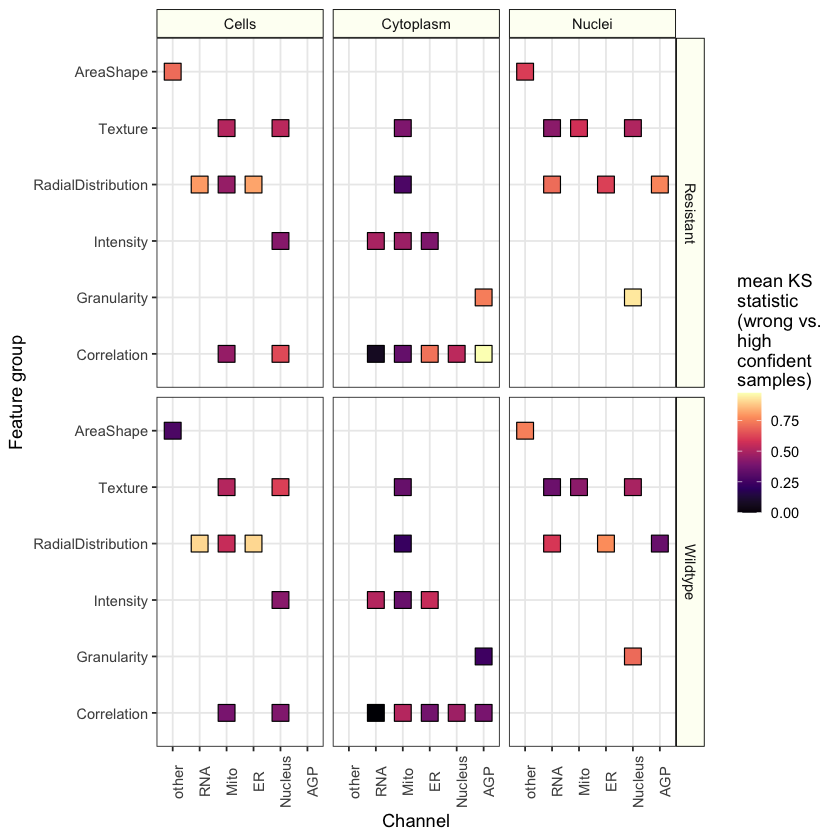

In [8]:
misclassified_summary_gg <- (
    ggplot(ks_test_group_mean_df, aes(x = channel_cleaned, y = feature_group))
    + geom_point(aes(fill = mean_ks_test), shape = 22, size = 5)
    + facet_grid("clone_type~compartment")
    + theme_bw()
    + theme(
        axis.text.x = element_text(angle = 90),
        strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
        ),
        legend.spacing.y = unit(0.1, "cm"),
        legend.box.spacing = unit(0.5, "cm"),
        legend.key.size = unit(1, "lines"),
        legend.key.width = unit(1, "lines")
    )
    + labs(x = "Channel", y = "Feature group")
    + scale_fill_viridis_c(name = "mean KS\nstatistic\n(wrong vs.\nhigh\nconfident\nsamples)", option = "magma")
)

misclassified_summary_gg

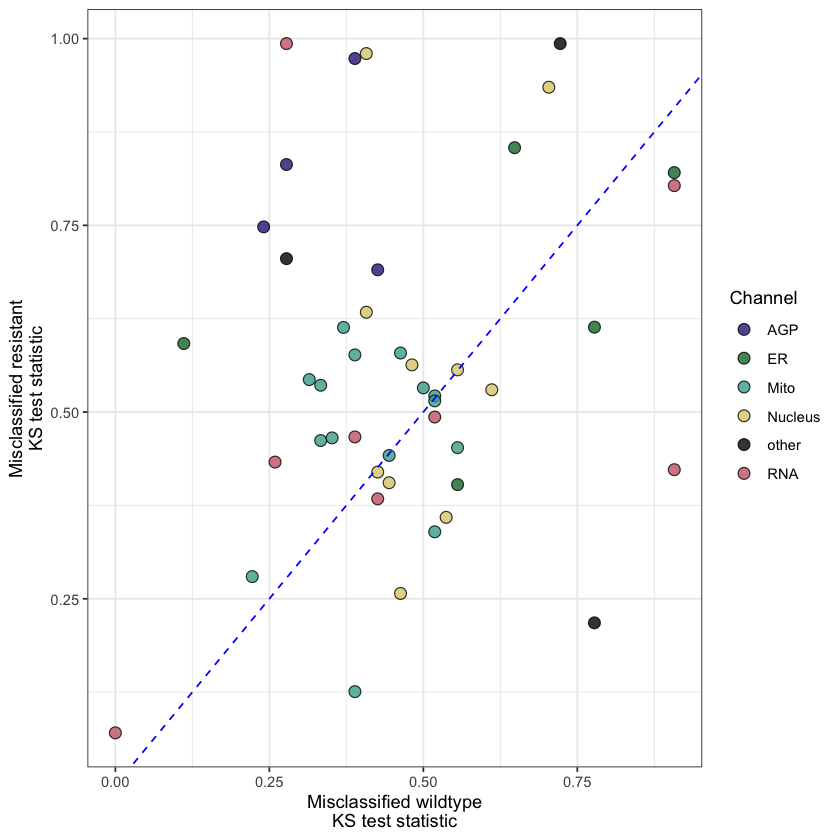

In [9]:
ks_test_comparison_df <- ks_test_df %>%
    dplyr::select(feature, clone_type, channel_cleaned, ks_stat) %>%
    tidyr::pivot_wider(names_from = clone_type, values_from = ks_stat)

ks_test_gg <- (
    ggplot(ks_test_comparison_df, aes(x = wildtype, y = resistant))
    + geom_point(
        aes(fill = channel_cleaned),
        shape = 21,
        size = 3,
        alpha = 0.8,
        color = "black"
    )
    + theme_bw()
    + labs(
        x = "Misclassified wildtype\nKS test statistic",
        y = "Misclassified resistant\nKS test statistic"
    )
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "blue")
    + scale_fill_manual(
        name = "Channel",
        labels = c(
            "AGP" =  "AGP",
            "ER" = "ER",
            "Mito" = "Mito",
            "Nucleus" = "Nucleus",
            "other" = "other",
            "RNA" = "RNA"
        ),
        values = c(
            "AGP" =  "#332288",
            "ER" = "#117733",
            "Mito" = "#44AA99",
            "Nucleus" = "#DDCC77",
            "other" = "black",
            "RNA" = "#CC6677"
        )
    )
)

ks_test_gg

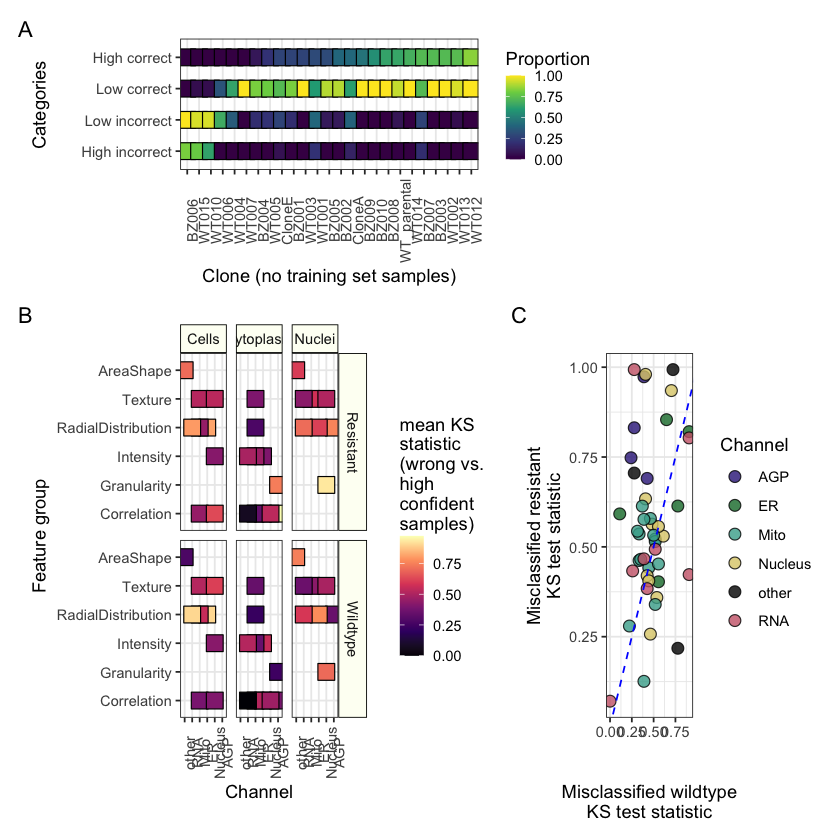

In [10]:
patchwork_plot <- (
    (
        (
            accuracy_summary_gg | plot_spacer()
        ) + plot_layout(widths = c(1, 0.25))
    )
    /
    (
        (
            misclassified_summary_gg
            + ks_test_gg
        ) + plot_layout(widths = c(1, 0.55))
    )
    )

patchwork_plot <- (
    patchwork_plot 
    + plot_annotation(tag_levels = "A")
    + plot_layout(heights = c(0.36, 1))
)

ggsave(output_file, patchwork_plot, height = 5.8, width = 10, dpi = 500)

patchwork_plot